## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import *

%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
np.random.seed(42)

`Question 1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

`a.` Read in the dataset and take a look at the top few rows here:

In [3]:
# import data
df = pd.read_csv('data/ab_data.csv')

# show top rows
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


`b.` Use the below cell to find the number of rows in the dataset.

In [4]:
# Calculate number of rows in dataset and display
df_length = len(df)         
print(df_length)

294478


`c.`Number of unique users in the dataset. 

In [5]:
# Calculate number of unique users in dataset
len(df.user_id.unique())

290584

`d.` The proportion of users converted.

In [6]:
df.converted.sum()/df_length

0.11965919355605512

`e.` The number of times the `new_page` and `treatment` don't line up. 

In [7]:
# Looking for rows where treatment/control doesn't line up with old/new pages respectively
df_t_not_n = df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')]
df_not_t_n = df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')]

# Add lengths
mismatch= len(df_t_not_n) + len(df_not_t_n)

# Create one dataframe from it
mismatch_df = pd.concat([df_t_not_n, df_not_t_n])

mismatch

3893

`f.` Do any rows have missing values?

In [8]:
# Check for missing values?
df.isnull().values.any()

False

`Question 2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows. As a result you can just remove the incremenating rows.

In [9]:
# Copy dataframe
df2 = df

# Remove incriminating rows
mismatch_index = mismatch_df.index
df2 = df2.drop(mismatch_index)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`Question 3`

`a.` How many unique user_ids are in df2?

In [11]:
# Find unique users
print("Unique users:", len(df2.user_id.unique()))

# Check for not unique users
print("Non-unique users:", len(df2)-len(df2.user_id.unique()))

Unique users: 290584
Non-unique users: 1


`b.` There is one user_id repeated in df2. What is it?

In [12]:
# Find duplicated user
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`c.` What is the row information for the repeat user_id? 

In [13]:
# Find duplicates under user ids
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`d.` Remove one of the rows with a duplicate user_id, keep dataframe as df2

In [14]:
# Drop duplicated user
df2.drop(labels=1899, axis=0, inplace=True)

In [15]:
# Check the drop worked
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`a.` What is the probability of an individual converting regardless of the page they receive?

In [16]:
# Probability of user converting
print("Probability of user converting:", df2.converted.mean())

Probability of user converting: 0.11959708724499628


`b.` Given that an individual was in the control group, what is the probability they converted?

In [17]:
# Probability of control group converting
print("Probability of control group converting:", 
      df2[df2['group']=='control']['converted'].mean())

Probability of control group converting: 0.1203863045004612


`c.` Given that an individual was in the treatment group, what is the probability they converted?

In [18]:
# Probability of treatment group converting
print("Probability of treatment group converting:", 
      df2[df2['group']=='treatment']['converted'].mean())

Probability of treatment group converting: 0.11880806551510564


`d.` What is the probability that an individual received the new page?

In [19]:
# Probability an individual recieved new page
print("Probability an individual recieved new page:", 
      df2['landing_page'].value_counts()[0]/len(df2))

Probability an individual recieved new page: 0.5000619442226688


`e.`  Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions? Write your response below.

According to the probabilities, the control group (the group with the old page) converted at a higher rate than the teatment (the group with the new page). 

<a id='ab_test'></a>
### Part II - A/B Test

`Question 1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

* Null-hypothesis

$H_0:  p_{new} - p_{old} \leq 0$ 

*i.e.* The null hypothesis is that the difference between the population conversion rate of users given the new page and the old page will be equal to zero (the same) or lower than zero (the old page has a higher population conversion rate).

* Alternative-hypothesis

$H_1: p_{new} - p_{old} > 0$

*i.e.* The alternative hypothesis is that the difference between the population conversion rate of users given the new page and the old page will be greater than zero to zero (the new page has a higher population conversion rate).


`Question 2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the converted success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page.

Use a sample size for each page equal to the ones in ab_data.csv.

Perform the sampling distribution for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null.


`a.` What is the **convert rate** for $p_{new}$ under the null? 

Given the assumption in the question, $p_{new} = p_{old}$. Hence, we should calculate the average of the real $p_{new}$ and $p_{old}$ (probability of conversion given new page and old page respectively) to calculate $p_{mean}$.

In [20]:
# Calculate probability of conversion for new page
p_new = df2[df2['landing_page']=='new_page']['converted'].mean()

print("Probability of conversion for new page (p_new):", p_new)

Probability of conversion for new page (p_new): 0.11880806551510564


In [21]:
# Calculate probability of conversion for old page
p_old = df2[df2['landing_page']=='old_page']['converted'].mean()

print("Probability of conversion for old page (p_old):", p_old)

Probability of conversion for old page (p_old): 0.1203863045004612


In [49]:
df2["converted"].mean()

0.11959708724499628

In [23]:
# Calc. differences in probability of conversion for new and old page (not under H_0)
p_diff = p_new-p_old

print("Difference in probability of conversion for new and old page (not under H_0):", p_diff)

Difference in probability of conversion for new and old page (not under H_0): -0.0015782389853555567


Hence:

$p_{new}: 0.1188$

$p_{old}: 0.1204$

`a.`  What is the **convert rate** for $p_{new}$ under the null? 

$p_{mean}=p_{old_0}=p_{new_0}: 0.1196$

`b`. What is the **convert rate** for $p_{old}$ under the null? <br><br>

As above.

$p_{new_0} - p_{old_0}= 0$



In [50]:
# Calculate n_new and n_old
n_new, n_old = df2['landing_page'].value_counts()

print("new:", n_new, "\nold:", n_old)

new: 145310 
old: 145274


Hence:

`c`. What is $n_{new}$? (Number of tests with the new page)

$n_{new}: 145310$

`d`. What is $n_{old}$? (Number of tests with the old page)

$n_{old}: 145274$

`e`. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null. Store these $n_{new}$ 1's and 0's in new_page_converted.

In [51]:
[p_mean, (1-p_mean)]

[0.11959718500778342, 0.8804028149922166]

In [25]:
# Simulate conversion rates under null hypothesis
# [0.11959718500778342, 0.8804028149922166] % choose [1, 0]
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_mean, (1-p_mean)])

new_page_converted.mean()

0.11979216846741449

`f.` Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [54]:
# Simulate conversion rates under null hypothesis
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_mean, (1-p_mean)])

old_page_converted.mean()

0.11990445640651459

`g` Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
# Calculate difference in p under the null hypothesis
new_page_converted.mean()-old_page_converted.mean()

0.0005416487598274428

`h.` Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [28]:
## Good, I like these simulations. 
p_diffs = []

# Re-run simulation 10,000 times
# trange creates an estimate for how long this program will take to run
for i in trange(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_mean, (1-p_mean)])
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_mean, (1-p_mean)])
    p_diff = new_page_converted.mean()-old_page_converted.mean()
    p_diffs.append(p_diff)
    

100%|██████████| 10000/10000 [01:33<00:00, 106.56it/s]


`i.` Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

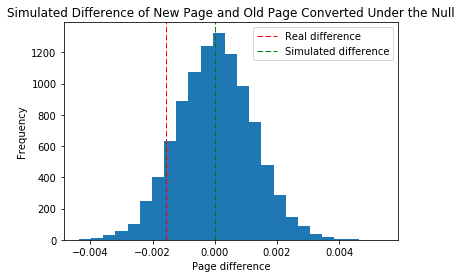

In [29]:
# Plot histogram
plt.hist(p_diffs, bins=25)
plt.title('Simulated Difference of New Page and Old Page Converted Under the Null')
plt.xlabel('Page difference')
plt.ylabel('Frequency')
plt.axvline(x=(p_new-p_old), color='r', linestyle='dashed', linewidth=1, label="Real difference")
plt.axvline(x=(np.array(p_diffs).mean()), color='g', linestyle='dashed', linewidth=1, label="Simulated difference")
plt.legend()
plt.show()


The simulated data creates a normal distribution (no skew) as expected due to how the data was generated. The mean of this normal distribution is 0, which which is what the data should look like under the null hypothesis.

`j`. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
p_diff = p_new - p_old

In [31]:
# Find proportion of p_diffs greater than the actual difference
greater_than_diff = [i for i in p_diffs if i > p_diff]

In [32]:
# Calculate values
print("Actual difference:" , p_diff)

p_greater_than_diff = len(greater_than_diff)/len(p_diffs)

print('Proportion greater than actual difference:', p_greater_than_diff)

print('As a percentage: {}%'.format(p_greater_than_diff*100))

Actual difference: -0.0015782389853555567
Proportion greater than actual difference: 0.9065
As a percentage: 90.64999999999999%


The above number makes sense because the probability for a conversion of a new page is lower than both the mean and old page conversion rates. 

`k.` In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

If our sample conformed to the null hypothesis then we'd expect the proportion greater than the actual difference to be 0.5. However, we calculate that almost 90% of the population in our simulated sample lies above the real difference which does not only suggest that the new page does not do significantly better than the old page, it might even be worse! 

The value calculated above is the p-value.

`l.` We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
# Import statsmodels
import statsmodels.api as sm

# Calculate number of conversions
# Some of these values were defined ealier in this notebook: n_old and n_new

convert_old = len(df2[(df2['landing_page']=='old_page')&(df2['converted']==1)])
convert_new = len(df2[(df2['landing_page']=='new_page')&(df2['converted']==1)])

print("convert_old:", convert_old, 
      "\nconvert_new:", convert_new,
      "\nn_old:", n_old,
      "\nn_new:", n_new)


/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


convert_old: 17489 
convert_new: 17264 
n_old: 145274 
n_new: 145310


`m.` Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
# Find z-score and p-value
z_score, p_value = sm.stats.proportions_ztest(count=[convert_new, convert_old], 
                                              nobs=[n_new, n_old])
print("z-score:", z_score,
     "\np-value:", p_value)

z-score: -1.3109241984234394 
p-value: 0.18988337448195103


`n.` What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>Simply put, a z-score is the number of standard deviations from the mean a data point is. But more technically it’s a measure of how many standard deviations below or above the population mean a raw score is

-[Source](http://www.statisticshowto.com/probability-and-statistics/z-score/)

Given the above definition, it would seem that the differences between the lines shown in the histogram above is -1.31 standard deviations. The p-value is roughly 19.0% which is the probability that this result is due to random chance, this is not enough evidence to reject the null hypothesis and thus we fail to do so.

<a id='regression'></a>
### Part III - A regression approach
Much easier approach, normality assumptions

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

You can use a [logistic regression](http://blog.yhat.com/posts/logistic-regression-python-rodeo.html).

This will likely be the `sm` [module](http://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.html) to use. 



`b.` The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [55]:
df3.head()

,user_id,timestamp,group,landing_page,ab_page,intercept,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,0,1,1


In [35]:
df3 = df2 # Clone dataframe in case of a mistake

df3['intercept'] = pd.Series(np.zeros(len(df3)), index=df3.index)
df3['ab_page'] = pd.Series(np.zeros(len(df3)), index=df3.index)

# Find indexes that need to be changed for treatment group
index_to_change = df3[df3['group']=='treatment'].index

# Change values
df3.set_value(index=index_to_change, col='ab_page', value=1)
df3.set_value(index=df3.index, col='intercept', value=1)

# Change datatype
df3[['intercept', 'ab_page']] = df3[['intercept', 'ab_page']].astype(int)

# Move "converted" to RHS
df3 = df3[['user_id', 'timestamp', 'group', 'landing_page', 'ab_page', 'intercept', 'converted']]

# Set up logistic regression
logit = sm.Logit(df3['converted'], df3[['ab_page', 'intercept']])

# Calculate results
result=logit.fit()

result.summary2() # result.summary() wasn't working for some reason, but this one does

In [38]:
# Check everything  has worked
df3[df3['group']=='treatment'].head()

,user_id,timestamp,group,landing_page,ab_page,intercept,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,1,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


`c.` Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

`d.` Provide the summary of your model below, and use it as necessary to answer the following questions.

`e.` What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

Apparently the p-value associated with `ab_page` is 0.1899, which is slightly lower than the p-value I calculated using the z-test above. The reason why the value is lower is because I added an intercept which is meant to account for bias. This means that this value is more accurate. (As in, it's probably closer to the true p-value)

However, this p-value is still much too high to reject the null hypothesis.

`f.` Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

There are certainly disadvantages to adding too many features into your analysis. When do you regression or categorization analysis you want to have features which have large impacts on outcome, small impacts are usually not influencial and should be left for the intercept. 

I believe there's a statistic which accounts for this, some sort of corrected R² value (in linear regression at least) which will give lower outputs if "useless" features are added.

However, only one feature was chosen to determine whether a user would convert (beside the intercept) so a couple of added features wouldn't hurt. I would imagine some features like the time spent looking at page and the date the page was designed might be some interesting features to add. The longer a customer spends on a page the more they are likely to be content with it and unwilling to change, it could also be the case that really old pages will not work well and people will want an updated version.

`g.` Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [42]:
# Importing data
df_countries = pd.read_csv('data/countries.csv')

df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [43]:
# Creating dummy variables
df_dummy = pd.get_dummies(data=df_countries, columns=['country'])

# Performing join
df4 = df_dummy.merge(df3, on='user_id') # df.join is depricated AFAIK

# Sorting columns
df4 = df4[['user_id', 'timestamp', 'group', 'landing_page', 
           'ab_page', 'country_CA', 'country_UK', 'country_US',
           'intercept', 'converted']]

# Fix Data Types
df4[['ab_page', 'country_CA', 'country_UK', 'country_US','intercept', 'converted']] =\
df4[['ab_page', 'country_CA', 'country_UK', 'country_US','intercept', 'converted']].astype(int)

df4.head()

,user_id,timestamp,group,landing_page,ab_page,country_CA,country_UK,country_US,intercept,converted
0,834778,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
1,928468,2017-01-23 14:44:16.387854,treatment,new_page,1,0,0,1,1,0
2,822059,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0,1,1
3,711597,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
4,710616,2017-01-16 13:14:44.000513,treatment,new_page,1,0,1,0,1,0


In [44]:
# Create logit_countries object
logit_countries = sm.Logit(df4['converted'], 
                           df4[['country_UK', 'country_US', 'intercept']])

# Fit
result2 = logit_countries.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [45]:
# Show results
result2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-07-01 12:57 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
country_UK     0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
country_US     0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
==================================================================

"""

It seems that country did have some bearing on conversion rate, but not high enough to be satistically significant

`h.` Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there are significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
# Create logit_countries object
logit_countries2 = sm.Logit(df4['converted'], 
                           df4[['ab_page', 'country_UK', 'country_US', 'intercept']])

# Fit
result3 = logit_countries2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [47]:
# Show results
result3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-07-01 12:58 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
country_UK     0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
country_US     0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
==================================================================

"""

When adding everything together it seems that the p-values for all featues has increased. The z-score for the intercept is incredibly large though which is interesting. 

<a id='conclusions'></a>
## Conclusions

Although it would seem from the outset that there is a difference between the conversion rates of new and old pages, there is just not enough evidence to reject the null hypothesis. From the histogram shown in this report, it seems that the new page does worse than the old pa.

It was also found that this was not dependent on countries with conversion rates being roughly the same in the UK as in the US. The test conditions were fairly good as well, users had a roughly 50% chance to recieve the new and old pages and the sample size of the initial dataframe is sufficiently big such that collecting data is likely not a good use of resources.

I would recommend that the e-commerce company spend their money on trying to improve their website before trying again. If anything, perhaps do some reason into why the page performed so poorly.